# Exploring multi-scale materials simulations with open access tools

## Part 1: Quantum Mechanics – Bond Strength

This tutorial shows how to run a simple DFT simulation to calculate bond strengths in molecules using the open-access GPAW code. 

GPAW relies on the Plane-Wave Augmented Basis, with a basis representation using a finite-difference grid in 3D. In opposition to other DFT code like VASP which uses plane waves in reciprocal space

Outline:
Tools- ASE + GPAW (easy to install via pip)
Set up a diamond and graphite unit cell.
Perform E vs. strain or E vs. bond-length scan.
Fit quadratic, get elastic moduli or bond stiffness.
Output: Plot energy vs. distance to show sp² vs sp³ bonding.

In [1]:
from gpaw import GPAW, PW
from ase.build import bulk

In [4]:
from ase.build import bulk, graphene_nanoribbon
from ase import Atoms
from ase.visualize import view
from ase.optimize import BFGS
from ase.units import kJ
import numpy as np
import matplotlib.pyplot as plt

In [30]:
from ase.constraints import FixBondLengths
from gpaw import LCAO 

In [ ]:
# Step 1 : Create structures with ASE 
# Small diamond and graphite fragments with vacuum to isolate them
diamond_atoms = bulk('C', 'diamond', a=3.57, cubic=True) #define unit cell 
graphite_atoms = graphene_nanoribbon(3, 2, type='armchair', vacuum=1) #, vacuum=4.0


In [ ]:
# Use ASE's built-in visualizer to view the structures
view(diamond_atoms)
view(graphite_atoms)


#if you want to use the nglview package, you can use the following code:
#import nglview as nv
#nv.show_ase(diamond_atoms)
#nv.show_ase(graphite_atoms)

<Popen: returncode: None args: ['/Users/acs/miniforge3/envs/gpaw-intel/bin/p...>

In [ ]:
# Step 2: Define DFT calculator (low-accuracy, plane-wave basis)
calc_diamond = GPAW(mode=PW(300), xc='PBE', txt='diamond_calc.log')
calc_graphite = GPAW(mode=PW(300), xc='PBE', txt='graphite_calc.log')

In [ ]:
# Step 2: Optimize both structures with BFGS algorithm
diamond_atoms.calc = calc_diamond
opt_diamond = BFGS(diamond_atoms, logfile='diamond_optim.log')
opt_diamond.run(fmax=0.05)

True

In [73]:
graphite_atoms.calc = calc_graphite
opt_graphite = BFGS(graphite_atoms, logfile='graphite_optim.log')
opt_graphite.run(fmax=0.05)

#This can take between 5-20 mintues to run

True

For viewing you can use nglview or the native ASE view function. nglview will work inline jupyter notebooks (if you are not using VSCode and you have ipywidgets configured properly) - ASE view will show as an external window

In [ ]:
# Step 3: Define a function to stretch a bond and compute relaxed energies
def stretch_bond(atoms, bond_atom_indices, stretch_factors, label):
    energies = []
    for i, sf in enumerate(stretch_factors):
        atoms_copy = atoms.copy()
        i1, i2 = bond_atom_indices
        d = atoms_copy.get_distance(i1, i2)
        atoms_copy.set_distance(i1, i2, d * sf, fix=0)
        atoms_copy.set_constraint(FixBondLengths([(i1, i2)]))
        atoms_copy.calc = GPAW(mode=LCAO(), xc='PBE', txt=f'{label}_scan_step_{i}.log')
        opt = BFGS(atoms_copy, logfile=None)
        opt.run(fmax=0.05)
        e = atoms_copy.get_potential_energy()
        energies.append(e)
    return energies

# Step 4: Choose stretch range and bonded atoms
stretch_factors = np.linspace(0.9, 1.1, 9)

# Select first bonded atoms (visual inspection recommended)
bond_indices_diamond = (0, 1)
bond_indices_graphite = (0, 1)


In [ ]:
energies_graphite = stretch_bond(graphite_atoms, bond_indices_graphite, stretch_factors, label='graphite')

#this took 35 minutes to run

In [ ]:
# Step 6: Energy vs bond length scan
def stretch_bond(atoms, bond_atom_indices, stretch_factors):
    energies = []
    for sf in stretch_factors:
        atoms_copy = atoms.copy()
        i, j = bond_atom_indices
        d = atoms_copy.get_distance(i, j)
        atoms_copy.set_distance(i, j, d * sf, fix=0)

        atoms_copy.calc = GPAW(mode=PW(300), xc='PBE', txt=None)
        e = atoms_copy.get_potential_energy()
        energies.append(e)
    return energies

In [ ]:
# Example: stretch first C–C bond in diamond
bond_indices = (0, 1)
stretch_factors = np.linspace(0.9, 1.1, 9)
energies_diamond = stretch_bond(diamond_atoms, bond_indices, stretch_factors)

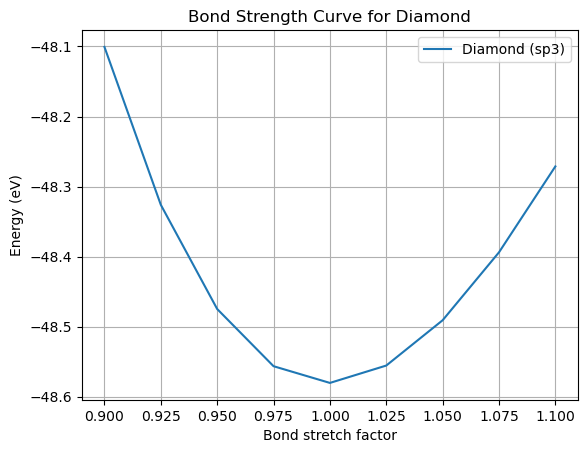

In [ ]:
# Plot energy vs bond stretch
plt.plot(stretch_factors, energies_diamond, label='Diamond (sp3)')
plt.xlabel('Bond stretch factor')
plt.ylabel('Energy (eV)')
plt.legend()
plt.title('Bond Strength Curve for Diamond')
plt.grid(True)
plt.show()

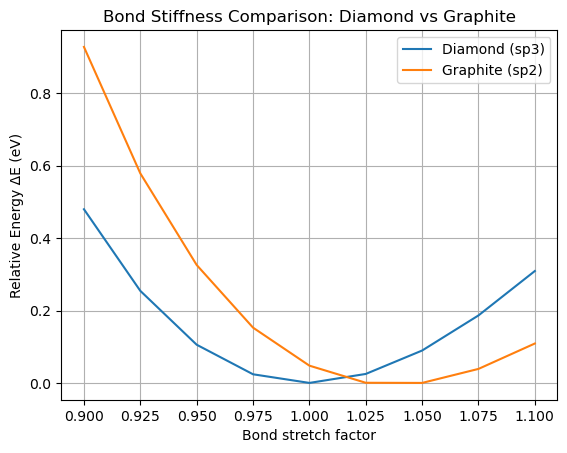

In [46]:
# Convert to relative energy curves (minimum = 0)
energies_diamond_rel = np.array(energies_diamond) - min(energies_diamond)
energies_graphite_rel = np.array(energies_graphite) - min(energies_graphite)

# Plot
plt.plot(stretch_factors, energies_diamond_rel, label='Diamond (sp3)')
plt.plot(stretch_factors, energies_graphite_rel, label='Graphite (sp2)')
plt.xlabel('Bond stretch factor')
plt.ylabel('Relative Energy ΔE (eV)')
plt.legend()
plt.title('Bond Stiffness Comparison: Diamond vs Graphite')
plt.grid(True)
plt.show()

In [48]:
from scipy.optimize import curve_fit

# Quadratic model: ∆E = 0.5 * k * (r - r0)^2
def harmonic(r, k, r0):
    return 0.5 * k * (r - r0)**2

# Convert stretch factor to absolute bond length
r0_diamond = diamond_atoms.get_distance(*bond_indices_diamond)
r0_graphite = graphite_atoms.get_distance(*bond_indices_graphite)

rvals_diamond = stretch_factors * r0_diamond
rvals_graphite = stretch_factors * r0_graphite

# Initial guess: k ≈ 50 eV/Å², r0 ≈ observed minimum bond length
popt_diamond, _ = curve_fit(harmonic, rvals_diamond, energies_diamond_rel, p0=[50.0, r0_diamond])
popt_graphite, _ = curve_fit(harmonic, rvals_graphite, energies_graphite_rel, p0=[50.0, r0_graphite])


k_diamond, r0_fit_diamond = popt_diamond
k_graphite, r0_fit_graphite = popt_graphite


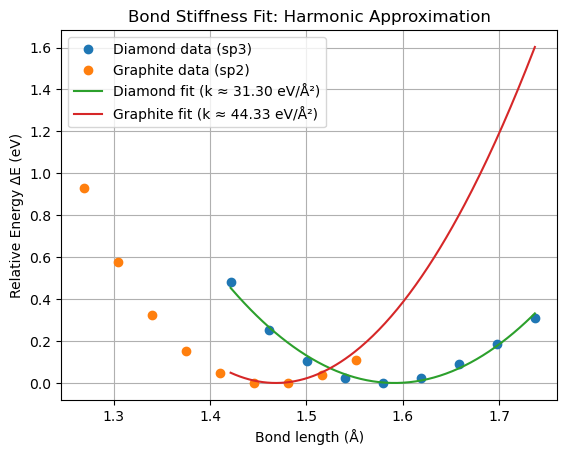

In [49]:
# Generate smooth curves for plotting
rfit = np.linspace(min(rvals_diamond), max(rvals_diamond), 200)
Efit_diamond = harmonic(rfit, *popt_diamond)
Efit_graphite = harmonic(rfit, *popt_graphite)

plt.plot(rvals_diamond, energies_diamond_rel, 'o', label='Diamond data (sp3)')
plt.plot(rvals_graphite, energies_graphite_rel, 'o', label='Graphite data (sp2)')
plt.plot(rfit, Efit_diamond, '-', label=f'Diamond fit (k ≈ {k_diamond:.2f} eV/Å²)')
plt.plot(rfit, Efit_graphite, '-', label=f'Graphite fit (k ≈ {k_graphite:.2f} eV/Å²)')

plt.xlabel('Bond length (Å)')
plt.ylabel('Relative Energy ΔE (eV)')
plt.title('Bond Stiffness Fit: Harmonic Approximation')
plt.legend()
plt.grid(True)
plt.show()


Part 2: 

Part 2: Atomistic Simulation – Fracture Behavior

Create simple 2D slabs of diamond and graphite with ASE.

Assign appropriate interatomic potential

Pull on one end of the structure and observe fracture.

Animate stress-strain or atomic motion using OVITO.

Part 3: Continuum – Elastic Field & Crack Propagation

